In [1]:
import os
import warnings
import cv2
import keras
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from PIL import Image
from PIL.ImageQt import rgb
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

style.use('seaborn-whitegrid')
warnings.filterwarnings(action='once')

Using TensorFlow backend.


In [2]:
gestures = {
    'H_': 'H',
    'E_': 'E',
    'L_': 'L',
    'O_': 'O',
    'W_': 'W',
    'R_': 'R',
    'D_': 'D'
}

gestures_map = {
    'H': 0,
    'E': 1,
    'L': 2,
    'O': 3,
    'W': 4,
    'R': 5,
    'D': 6
}

In [3]:
def process_image(path):
    img = Image.open(path)
    img = img.resize((224, 224))
    img = np.array(img)
    return img

def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data)
    return X_data, y_data

def walk_file_tree(relative_path):
    X_data = []
    y_data = []
    for directory, subdirectories, files in os.walk(relative_path):
        for file in files:
            if not file.startswith('.') and not file.startswith('C_'):
                path = os.path.join(directory, file)
                gesture_name = gestures[file[0:2]]
                y_data.append(gestures_map[gesture_name])
                X_data.append(process_image(path))
            else:
                continue

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

class Data(object):
    def __init__(self):
        self.X_data = []
        self.y_data = []

    def get_data(self):
        return self.X_data, self.y_data

In [6]:
relative_path = './data/'

X_data, y_data = walk_file_tree(relative_path)

silhouette = Data()
silhouette.X_data, silhouette.y_data = walk_file_tree(relative_path)

In [7]:
print(f'X_data shape: {X_data.shape}')
print(f'y_data shape: {y_data.shape}')

X_data shape: (3575, 224, 224, 3)
y_data shape: (3575, 7)


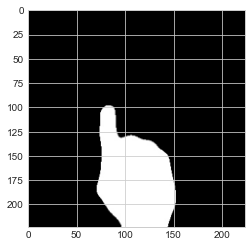

In [8]:
plt.imshow(X_data[0])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=42, stratify=y_data)

In [10]:
file_path = './models/saved_model.hdf5'
model_checkpoint = ModelCheckpoint(filepath=file_path, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)

In [ ]:
# Обучаем модель на основе VGG16
image_size = 224
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
optimizer1 = optimizers.Adam()

base_model = model1
# Добавляем верхний слой
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)

predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Обучаем верхний слой
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_train, y_train), verbose=1,
          callbacks=[early_stopping, model_checkpoint])

c:\projects\awesomesignrecognition\venv\lib\site-packages\keras\engine\training_utils.py:811: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(loss, collections.Mapping):
c:\projects\awesomesignrecognition\venv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Train on 2860 samples, validate on 2860 samples
Epoch 1/50
2560/2860 [=========================>....] - ETA: 1:01 - loss: 1.1339 - accuracy: 0.5793

In [ ]:
model.save('./models/VGG.h5')

from keras.models import load_model
model = load_model('./models/VGG.h5')

In [ ]:
def get_classification_metrics(X_test, y_test):
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(confusion_matrix(y_true, pred))
    print('\n')
    print(classification_report(y_true, pred))


In [ ]:
get_classification_metrics(X_test, y_test)


